In [949]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd
from scipy.optimize import curve_fit
from tensorflow.keras.callbacks import Callback

In [950]:
data = pd.read_csv("./data.csv")
print(data.head())

train_data = data[data["subject"] == 1]["shape_num"].to_numpy()

RT_train_data = data[data["subject"] == 1]["RT_trimmed"].to_numpy()
print("RT_train_data", RT_train_data)

print(train_data.shape)

real_y = train_data[:24]
real_y_add = train_data[24:24*2]
print(real_y)
print(real_y_add)

def gen_data(d):
    data = np.empty((0, 24))
    for index in d:
        #print("item?: ", index)
        # Create an array of zeros with length 24
        result_array = np.zeros(24)
        result_array[d[index] - 1] = 1
        data = np.vstack((data, result_array))
    return data

X_train_all = gen_data(train_data)

"""
y train creation:

Hetzelfde maar dus elke keer item van de volgende in de lijst en elke na 3de element is [0,...,0]
"""

y_train_all = X_train_all.copy()
y_train_all[:-1] = y_train_all[1:]


print("y_train_all.shape", y_train_all.shape[0] / 3)

y_train_all[2::3] = np.zeros(
    (int(y_train_all.shape[0]/3), 24)
)



#X_train = X_train[24:24*2]
#y_train = y_train[24:24*2]

#X_train = X_train[:576-24]
#y_train = y_train[:576-24]

#X_train = X_train[:576-24]
#y_train = y_train[:576-24]

X_train = X_train_all[:-24*1]
y_train = y_train_all[:-24*1]

#X_train = X_train_all[:24*4]
#y_train = y_train_all[:24*4]


X_test = X_train_all[576-(24*1):]
y_test = y_train_all[576-(24*1):]

print(X_test.shape, y_test.shape)
print("show inner", X_test, X_train)

#X_test = X_train_all[24:48]
#y_test = y_train_all[24:48]



"""
X_test = X_train[24*3:24*4]
y_test = y_train[24*3:24*4]
"""

#X_train = np.reshape(X_train, (24, -1, 24))
#X_test = np.reshape(X_test, (24, -1, 24))

X_train = np.reshape(X_train, (-1, 24, 24))
X_test = np.reshape(X_test, (-1, 24, 24))

#X_train = np.reshape(X_train, (-1, 1, 24))
#X_test = np.reshape(X_test, (-1, 1,  24))

#y_train = np.reshape(y_train, (24, -1, 24))
#y_test = np.reshape(y_test, (24, -1, 24))

#y_train = np.reshape(y_train, (-1, 1, 24))
#y_test = np.reshape(y_test, (-1, 1, 24))

y_train = np.reshape(y_train, (-1, 24, 24))
y_test = np.reshape(y_test, (-1, 24, 24))

print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)
print(X_test)

   subject         ave          sd  block  triplet  position  shape_num    RT  \
0        1  463.309028  298.476633      1        1         1          1  1121   
1        1  463.309028  298.476633      1        1         2          2   886   
2        1  463.309028  298.476633      1        1         3          3   837   
3        1  463.309028  298.476633      1        7         1         19   843   
4        1  463.309028  298.476633      1        7         2         20  1264   

    RT_trimmed  log_RT_trimmed  change?  block>12  block>18  block>6  \
0  1060.262293        6.966272        1     False     False    False   
1   886.000000        6.786717        0     False     False    False   
2   837.000000        6.729824        0     False     False    False   
3   843.000000        6.736967        0     False     False    False   
4  1060.262293        6.966272        1     False     False    False   

   1-avg(2,3)  log_1-avg(2,3) odd_even  
0         NaN             NaN        o 

## Simulate based on custom dataset

In [951]:
# Full dataset - 1 block


## Build network wth GRU

In [952]:
def build_network(learning_rate: float = 0.05):
      model = tf.keras.Sequential()
      model.add(tf.keras.Input(shape=(1,24)))
      #model.add(tf.keras.layers.SimpleRNN(units=64, return_sequences = True, activation = "tanh"))
      model.add(tf.keras.layers.GRU(units=64, return_sequences = True, activation = "tanh"))
      #model.add(tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(units=24, activation="softmax")))  # Output shape should match the number of features
      model.add(tf.keras.layers.Dense(units=24, activation = "softmax")) 
      loss = tf.keras.losses.CategoricalCrossentropy()
      model.compile(optimizer = \
         tf.keras.optimizers.Adam(learning_rate = learning_rate), loss = loss, metrics = ["accuracy"])	
      return model


In [953]:
class PredictionsCallback(Callback):
    def __init__(self, X_test):
        self.X_test = X_test
        self.batch_predictions = np.array([])

    def on_batch_end(self, batch, logs=None):
        predictions = self.model.predict(self.X_test)
        # You can do something with the predictions here, like save them or print them
        self.batch_predictions = np.append(self.batch_predictions, predictions)
        print("Predictions after batch {}: {} :: shape: {}".format(batch, predictions, predictions.shape))


    def on_epoch_end(self, epoch, logs=None):
        predictions = self.model.predict(self.X_test)
        # You can do something with the predictions here, like save them or print them
        print("Predictions for epoch {}: {}".format(epoch, predictions))
        
    def get_predictions(self):
        return self.batch_predictions

def train_model():
    print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)
    
    # Initialize the custom callback with the test data
    predictions_callback = PredictionsCallback(X_test)
    
    
    res = model.fit(X_train, y_train, epochs=1, batch_size=1, verbose=1, callbacks=[predictions_callback])

    
    print(res)
    return (res, predictions_callback.get_predictions())


In [954]:
"""
def train_model():
    print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)
    res = model.fit(X_train, y_train, epochs = 24, verbose=1)
    return res
"""

'\ndef train_model():\n    print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)\n    res = model.fit(X_train, y_train, epochs = 24, verbose=1)\n    return res\n'

In [955]:
def show_res(res, verbose: bool = False):
    if verbose:
        print(res.history)
    fig, axs = plt.subplots(2,2)
    axs[0, 0].set_title("training loss")
    axs[0, 0].plot(res.history["loss"])
    axs[0, 1].set_title("training accuracy")
    axs[0, 1].plot(res.history["accuracy"])
    axs[1, 0].set_title("test loss")
    #axs[1, 0].plot(res.history["val_loss"])
    axs[1, 1].set_title("test accuracy")
    #axs[1, 1].plot(res.history["val_accuracy"])
    plt.show()

(23, 24, 24) (23, 24, 24) (1, 24, 24) (1, 24, 24)
 1/23 [>.............................] - ETA: 21s - loss: 2.1154 - accuracy: 0.0000e+00WARNING:tensorflow:Model was constructed with shape (None, 1, 24) for input KerasTensor(type_spec=TensorSpec(shape=(None, 1, 24), dtype=tf.float32, name='input_80'), name='input_80', description="created by layer 'input_80'"), but it was called on an input with incompatible shape (None, 24, 24).
Predictions after batch 0: [[[0.04143378 0.03434571 0.06289854 0.03854235 0.03851869 0.04013186
   0.0468327  0.04167101 0.04080878 0.04184957 0.04751939 0.04129056
   0.04941936 0.03643539 0.03633516 0.0465108  0.03492577 0.04465209
   0.04690354 0.0335754  0.04006301 0.04340112 0.03573264 0.0362028 ]
  [0.0399464  0.03130597 0.04989843 0.03618951 0.04086613 0.04033893
   0.0499647  0.03331586 0.04209407 0.03663787 0.04224859 0.0354252
   0.04742796 0.03709155 0.04456278 0.04653496 0.03342282 0.05317879
   0.07154735 0.02864737 0.04634039 0.03979172 0.0355669

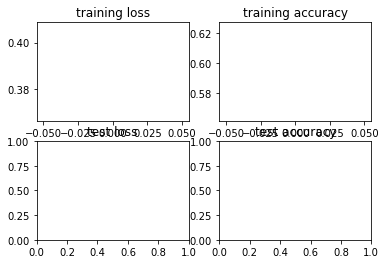

In [956]:
model = build_network()
res, pred_per_batch = train_model()
#res = train_model()
model.summary()

show_res(res)

#print(model.predict(X_test))
#print(model.predict(X_test).shape)

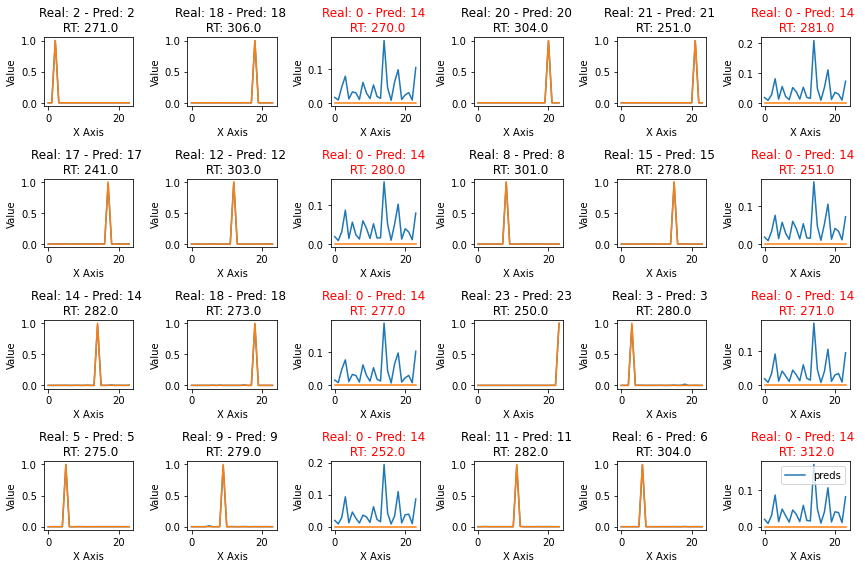

In [957]:
pred = model.predict(X_test)

# Create 24 subplots
fig, axes = plt.subplots(4, 6, figsize=(12, 8))

variances = np.empty(24)

for i, ax in enumerate(axes.flatten()):
    """
    print("i", i)
    #ax.plot(pred[i, 0, :])
    ax.plot(pred[i, 0, :], label="preds")
    print("pred: i, ", pred[i][0])
    ax.plot(y_test[i, 0, :])
    #ax.plot(y_test[i])
    ax.set_xlabel('X Axis')
    ax.set_ylabel('Value')
    ax.set_title(f'Plot {i+1}, {np.argmax(y_test[i])} - {np.argmax(pred[i, 0, :])}')
    """
    #print("i", i)
    #ax.plot(pred[i, 0, :])
    ax.plot(pred[0, i, :], label="preds")
    #print("pred: i, ", pred[0][i])
    ax.plot(y_test[0, i, :])
    #ax.plot(y_test[i])
    ax.set_xlabel('X Axis')
    ax.set_ylabel('Value')
    ax.set_title(
    f'Real: {np.argmax(y_test[0, i])} - Pred: {np.argmax(pred[0, i, :])}',
    color='{kleur}'.format(kleur="black" if np.argmax(y_test[0, i]) == np.argmax(pred[0, i, :]) else "red")
    )
    #print("var", np.var(pred[0, i, :]))
    variances[i] = np.var(pred[0, i, :])

plt.tight_layout()
plt.legend()
plt.show()

### Stronger predictions in late triplet component
More evident with increased epochs (ie 10 instead of 1)
Higher value (variance) meaning "faster" as more differentation is present

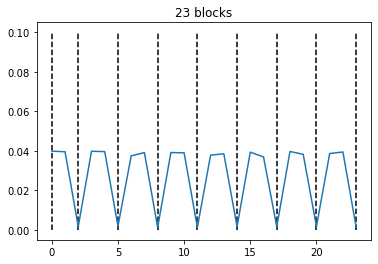

In [958]:
plt.plot(variances)
plt.title("23 blocks")
triplets = [0,2,5,8,11,14,17,20,23]
plt.vlines(triplets, ymin=0.0, ymax=0.1, color="black", linestyle="--")
plt.show()


### Online measure

In [959]:
# Generate a random 3D array for demonstration
preds = model.predict(X_test)
print(preds.shape)

# Find the index of the maximum value
max_index = np.argmax(preds[0, 0])
print(max_index)

# Create a new array with all zeros and set the maximum value to 1
new_array = np.zeros_like(np.arange(24))
new_array[max_index] = 1

# Print the result
print(new_array.shape)
print(preds[0])
print(new_array)
print(y_test[0])

(1, 24, 24)
2
(24,)
[[2.46500604e-05 6.35878314e-06 9.98894274e-01 7.74795772e-05
  1.05552499e-05 7.82745483e-05 1.32864094e-04 4.47292405e-05
  3.51559611e-05 2.48993219e-05 2.33158735e-05 1.57206858e-04
  3.96197465e-05 1.04773044e-05 1.75954483e-05 1.58915616e-04
  1.41668716e-05 1.10738452e-04 5.81681488e-05 1.51406775e-05
  5.94727408e-06 1.48565559e-05 2.77827639e-05 1.68620936e-05]
 [1.03264938e-05 2.01282069e-06 1.88818524e-06 6.70640584e-05
  3.49404581e-06 3.81653517e-04 6.51973009e-04 1.81754433e-06
  9.51109920e-04 1.42908593e-05 2.67149221e-06 2.79534197e-05
  1.82577987e-05 4.54172732e-06 1.09012166e-04 2.16308469e-03
  1.91239656e-06 1.63153200e-05 9.95401502e-01 3.75417898e-07
  4.52898748e-05 4.70581908e-05 1.34716970e-06 7.51893094e-05]
 [1.59360096e-02 8.35687853e-03 4.75732386e-02 7.93577507e-02
  1.14564486e-02 3.25609036e-02 2.95133255e-02 1.00824730e-02
  6.10617101e-02 2.94419192e-02 1.28080221e-02 5.31897359e-02
  1.87725537e-02 1.32235177e-02 1.85884282e-01 4

{'name': 'gru_78', 'trainable': True, 'dtype': 'float32', 'return_sequences': True, 'return_state': False, 'go_backwards': False, 'stateful': False, 'unroll': False, 'time_major': False, 'units': 64, 'activation': 'tanh', 'recurrent_activation': 'sigmoid', 'use_bias': True, 'kernel_initializer': {'class_name': 'GlorotUniform', 'config': {'seed': None}}, 'recurrent_initializer': {'class_name': 'Orthogonal', 'config': {'gain': 1.0, 'seed': None}}, 'bias_initializer': {'class_name': 'Zeros', 'config': {}}, 'kernel_regularizer': None, 'recurrent_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'recurrent_constraint': None, 'bias_constraint': None, 'dropout': 0.0, 'recurrent_dropout': 0.0, 'implementation': 2, 'reset_after': True}
{'name': 'dense_79', 'trainable': True, 'dtype': 'float32', 'units': 24, 'activation': 'softmax', 'use_bias': True, 'kernel_initializer': {'class_name': 'GlorotUniform', 'config': {'seed': None}}, 'bias_initial

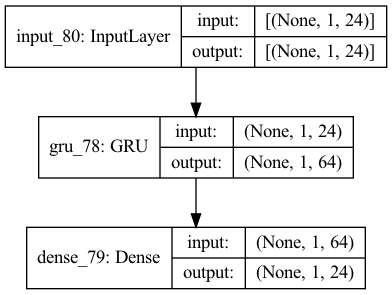

In [960]:
for layer in model.layers: 
    #print(layer.get_config(), layer.get_weights())
    print(layer.get_config())
    #print(np.array(layer.get_weights()))
    
# pydot and graphviz required voor plot
tf.keras.utils.plot_model(model, to_file="model_plot.png", show_shapes=True, show_layer_names=True)

Showing that variability increases between activation/prediction in increasingly more blocks

(23, 24, 24)
means (23, 24)
means (23, 24)


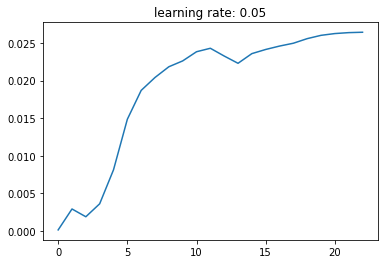

In [961]:
#print(pred_per_batch)
pred_per_batch = np.reshape(pred_per_batch, (-1, 24, 24))
print(pred_per_batch.shape)
#print(pred_per_batch[0])

means = np.mean(pred_per_batch, axis=2)
vars = np.var(pred_per_batch, axis=2)
print("means", means.shape)
print("means", vars.shape)


#plt.plot(np.var(means, axis=1))
plt.title("learning rate: 0.05")
plt.plot(np.mean(vars, axis=1))
#print("var;", np.var(pred_per_batch, axis=1))
#print("var;", np.var(pred_per_batch, axis=1).size)
plt.show()